## Hw3 Stereo

In [2]:
from __future__ import division, print_function
import glob
import os
import warnings
warnings.simplefilter("ignore")
import cv2
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from config_profile import args
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from Utils import L2Norm, cv2_scale, np_reshape
from scipy.optimize import linear_sum_assignment
from torch.nn.functional import normalize
import re
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


### Check GPU availability, using nvidia-smi 

In [3]:
# Since there are two GPUs on each pelican server, you can either select it as 0 or 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(torch.__version__)
print(torch.version.cuda)  
print(torch.cuda.is_available())

1.8.1+cu101
10.1
True


Get patches function

In [18]:
def getPatches(kps, img, size=32, num=100):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) 
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)

        cropped_img = img[ymin: ymax, xmin: xmax]
        ch, cw = cropped_img.shape
        res[i, 0, ymin_res: ymin_res+ch, xmin_res: xmin_res+cw] =  cropped_img
        
    return res

### Find the keypoints from query images and dataset images

In [19]:
keypoints = torch.zeros(5, 2, 100, 2)
patches = torch.zeros(5, 2, 100, 1, 32, 32)


img_dir = "images" 
if os.path.exists(img_dir):
    if os.listdir(img_dir) is []:
        print("No images!")
        exit(0)
    
    for i in range(5):
        
        image1_path = img_dir + "/image" + str(i+1) + str(1) + ".png"
        image2_path = img_dir + "/image" + str(i+1) + str(2) + ".png"
        
        image1 = cv2.imread(image1_path)
        image2 = cv2.imread(image2_path)
        
        gray1= cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
        gray2= cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)
        
        #print('1', image1_path)
        
        
        #SIFT Detector image1
        sift = cv2.xfeatures2d.SIFT_create(nfeatures=100)
        kp1, des1 = sift.detectAndCompute(gray1,None)
        #img1=cv2.drawKeypoints(gray1, kp1, None)
        kps1 = cv2.KeyPoint_convert(kp1)[:100]
        
        patches[i,0] = getPatches(kps1, gray1, size=32, num=100)
        keypoints[i,0] = torch.tensor(kps1)
        
        #plt.imshow(img1)
        #plt.show()
        
        #print('2', image2_path)
        
        #SIFT Detector image2
        kp2, des2 = sift.detectAndCompute(gray2,None)
        #img2=cv2.drawKeypoints(gray2, kp2, None)
        kps2 = cv2.KeyPoint_convert(kp2)[:100]
        
        patches[i,1] = getPatches(kps2, gray2, size=32, num=100)
        keypoints[i,1] = torch.tensor(kps2)
          
       
        #plt.imshow(img2)
        #plt.show()
        
    
#     print("patches1", len(all_patches1))
#     print("patches2", len(all_patches2))
        
            

else:
    print("image folder not exists!")
    exit(0)


In [20]:
print("all_patches", patches.shape)
print("all_keypoints", keypoints.shape)

all_patches torch.Size([5, 2, 100, 1, 32, 32])
all_keypoints torch.Size([5, 2, 100, 2])


### Load network weights

In [21]:
from our_CNN import DesNet
model = DesNet()

if args.cuda:
    model.cuda()

trained_weight_path = "models/our_checkpoint.pth" # suppose you select *checkpoint.pth as the best model for this architecture
test_model = DesNet()
if args.cuda:
    test_model.cuda()
trained_weight = torch.load(trained_weight_path)['state_dict']
test_model.load_state_dict(trained_weight)
test_model.eval()

DesNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): Re

### Get deep features

In [22]:
patches = model(patches.view(-1, 1, 32, 32).cuda()).view(5, 2, 100, 128).cpu().data

torch.save(keypoints, "all_keypoints.pth")
torch.save(patches, "all_patches.pth")

print('all_keypoints :', keypoints.shape)
print('all_pathces :', patches.shape)

all_keypoints : torch.Size([5, 2, 100, 2])
all_pathces : torch.Size([5, 2, 100, 128])


### Get M0 F0 F1

In [86]:
### test

pathces = torch.load("all_patches.pth")

f_q = pathces[0][0]
f_i = pathces[0][1]


cost = torch.zeros(100, 100)
simi = torch.zeros(100, 100)
simi1 = torch.zeros(100, 100)

for i in range(100):
    for j in range(100):
        simi[i,j] = (1 + F.cosine_similarity(f_q[i], f_i[j], dim=0))/2
        cost[i,j] = 1 - simi[i,j]
        simi1[i,j] = 1 - cost[i,j]
        row_ind, col_ind = linear_sum_assignment(cost.cpu().numpy())
        
print(simi)
print(simi1)
print(cost)


# simi[row_ind, col_ind]
# val, top = torch.topk(simi[row_ind, col_ind], k = 50)

# print(simi[row_ind, col_ind])
# print(top)

# for i in range(len(top)):
#     for j in range(len(row_ind)):
#         if simi[j, col_ind[j]] == val[i]:
#             print("row: ", row_ind[j], "  col: " ,col_ind[j], "  value: ", simi[j, col_ind[j]] )




tensor([[0.5701, 0.5090, 0.4967,  ..., 0.4740, 0.4653, 0.4997],
        [0.5803, 0.5513, 0.5633,  ..., 0.5793, 0.5562, 0.5989],
        [0.4959, 0.4494, 0.5744,  ..., 0.5077, 0.5244, 0.5244],
        ...,
        [0.4806, 0.4936, 0.4758,  ..., 0.4870, 0.5325, 0.5516],
        [0.4682, 0.4791, 0.5163,  ..., 0.5972, 0.6029, 0.5365],
        [0.4756, 0.5085, 0.4686,  ..., 0.4872, 0.6085, 0.5702]])
tensor([[0.5701, 0.5090, 0.4967,  ..., 0.4740, 0.4653, 0.4997],
        [0.5803, 0.5513, 0.5633,  ..., 0.5793, 0.5562, 0.5989],
        [0.4959, 0.4494, 0.5744,  ..., 0.5077, 0.5244, 0.5244],
        ...,
        [0.4806, 0.4936, 0.4758,  ..., 0.4870, 0.5325, 0.5516],
        [0.4682, 0.4791, 0.5163,  ..., 0.5972, 0.6029, 0.5365],
        [0.4756, 0.5085, 0.4686,  ..., 0.4872, 0.6085, 0.5702]])
tensor([[0.4299, 0.4910, 0.5033,  ..., 0.5260, 0.5347, 0.5003],
        [0.4197, 0.4487, 0.4367,  ..., 0.4207, 0.4438, 0.4011],
        [0.5041, 0.5506, 0.4256,  ..., 0.4923, 0.4756, 0.4756],
        ...,

In [12]:
def one2one_cost(image1_f, image2_f):
    total_row = []
    total_col = []
    cost = torch.zeros(100, 100)
    simi = torch.zeros(100, 100)
    for i in range(100):
        for j in range(100):
            simi[i,j] = (1 + F.cosine_similarity(image1_f[i], image2_f[j], dim=0))/2
            cost[i,j] = 1 - simi[i,j]
            row_ind, col_ind = linear_sum_assignment(cost.cpu().numpy())
    
    simi[row_ind, col_ind]
    val, top = torch.topk(simi[row_ind, col_ind], k = 50) #topk 50
    for i in range(len(top)):
        for j in range(len(row_ind)):
            if simi[j, col_ind[j]] == val[i]:
                #print("row: ", row_ind[j], "  col: " ,col_ind[j], "  value: ", simi[j, col_ind[j]] )
                total_row.append(row_ind[j])
                total_col.append(col_ind[j])
                
    return total_row, total_col

In [13]:
patches = torch.load("all_patches.pth")
keypoints = torch.load("all_keypoints.pth")
M0 = torch.zeros(5, 2, 50, 2)
F0 = torch.zeros(5, 3, 3)
F1 = torch.zeros(5, 3, 3)

for i in range(5):
    print("finished No.{} ".format(i+1))
    
    row_ind, col_ind = one2one_cost(patches[i,0], patches[i,1])
    M0[i, 0] = keypoints[i,0][row_ind]
    M0[i, 1] = keypoints[i,1][col_ind]
    points1 = M0[i, 0].numpy()
    points2 = M0[i, 1].numpy()
    f0, mask0 = cv2.findFundamentalMat(points1,points2,cv2.FM_8POINT)
    F0[i] = torch.tensor(f0)
    f1, mask1 = cv2.findFundamentalMat(points1,points2,cv2.FM_RANSAC)
    F1[i] = torch.tensor(f1)
    
    

finished No.1 
finished No.2 
finished No.3 
finished No.4 
finished No.5 


### Get F2 M1

In [14]:
def deep_features_appearance(df1, df2):
    cost = torch.zeros(100, 100)
    simi = torch.zeros(100, 100)
    for i in range(100):
        for j in range(100):
            simi[i,j] = (1 + F.cosine_similarity(df1[i], df2[j], dim=0))/2
            cost[i,j] = 1 - simi[i,j]
        
    return cost

def epipolar_cues(kps1, kps2, F1):
    B = torch.zeros(100, 100)
    
    one1 = torch.ones(kps1.shape[0])
    one2 = torch.ones(kps2.shape[0])
    one1 = one1.unsqueeze(1)
    one2 = one2.unsqueeze(1)
    
    kps1 = torch.cat((kps1,one1),1)
    kps2 = torch.cat((kps2,one2),1)
    
    for i in range(100):
        for j in range(100):
            b = torch.matmul(kps2[j].t(), F1)
            B[i,j] = torch.matmul(b, kps1[i])
            
    return torch.abs(B)

def another_one2one_cost(total_cost):
    total_row = []
    total_col = []
    simi = torch.zeros(100, 100)
    
    row_ind, col_ind = linear_sum_assignment(total_cost.cpu().numpy())
    
    for i in range(100):
        for j in range(100):
            simi[i,j] = 1 - cost[i,j]
    
#     print(simi)
#     print(row_ind)
#     print(col_ind)
#     print(simi)
#     print(cost)

    val, top = torch.topk(simi[row_ind, col_ind], k = 50) #topk 50
    
    
    for i in range(len(top)):
        for j in range(len(row_ind)):
            if simi[j, col_ind[j]] == val[i]:
                #print("row: ", row_ind[j], "  col: " ,col_ind[j], "  value: ", simi[j, col_ind[j]] )
                total_row.append(row_ind[j])
                total_col.append(col_ind[j])
    #print(len(row_ind))
    return total_row, total_col
    
    

In [15]:
patches = torch.load("all_patches.pth")
keypoints = torch.load("all_keypoints.pth")
M1 = torch.zeros(5, 2, 50, 2)
F2 = torch.zeros(5, 3 ,3)
cost_a = torch.zeros(5, 100, 100)
cost_b = torch.zeros(5, 100, 100)
lamb = 10

for i in range(5):
    print("finished No.{} ".format(i+1))
    df1 = patches[i,0]
    df2 = patches[i,1]
    kps1 = keypoints[i,0]
    kps2 = keypoints[i,1]
    cost_a[i] = deep_features_appearance(df1, df2)
    cost_b[i] = epipolar_cues(kps1, kps2, F1[i])
    cost_a[i] = normalize(cost_a[i], p=1.0)
    cost_b[i] = normalize(cost_b[i], p=1.0)
    cost = cost_a[i] + lamb * cost_b[i]
    row_ind, col_ind = another_one2one_cost(cost)
    M1[i, 0] = keypoints[i,0][row_ind]
    M1[i, 1] = keypoints[i,1][col_ind]
    points1 = M1[i, 0].numpy()
    points2 = M1[i, 1].numpy()
    f2, mask2 = cv2.findFundamentalMat(points1,points2,cv2.FM_RANSAC)
    F2[i] = torch.Tensor(f2)



    

finished No.1 
finished No.2 
finished No.3 
finished No.4 
finished No.5 


### Get fundamental.pth

### 

In [17]:
fundamentals = torch.stack((F0, F1, F2), dim=1)  #five 3x3 fundamental 
torch.save(fundamentals, "fundamental.pth")
print(fundamentals.shape)

torch.Size([5, 3, 3, 3])


### Get epipoles

In [22]:
def epipoleSVD(M):
    V = cv2.SVDecomp(M)[2]
    return V[-1]/V[-1,-1]

epipoles = torch.zeros(5, 3, 2, 3)

for i in range(5):
    for j in range(3):
        f = fundamentals[i, j]
        epi1 = epipoleSVD(f.numpy())                 # on image 1
        epi2 = epipoleSVD(f.permute(1,0).numpy())    # on image 2
        epi1 = torch.from_numpy(epi1)
        epi2 = torch.from_numpy(epi2)
        epipoles[i, j, 0] = epi1
        epipoles[i, j, 1] = epi2
        
        
torch.save(epipoles, "epipoles.pth")
print(epipoles.shape)
    

torch.Size([5, 3, 2, 3])


### Draw plot

In [19]:
def drawepipoles(image, epipoles, color):
    epipoles = np.int32(epipoles)
    image = cv2.circle(image,epipoles,5, color ,20)
    
    return image

def drawlines_new(image1, image2, kps1, kps2, lines0, lines1, lines2):
    r,c,l = image1.shape
    color1 = (255, 0, 0)
    color2 = (0, 255, 0)
    color3 = (0, 0, 255)
    
    image1 = cv2.circle(image1,tuple(kps1),5,(255, 255, 0),20) #draw dot in image1
    #image2 = cv2.circle(image2,tuple(kps2),5,(255, 255, 0),20) #draw dot in image2
    
    if lines0 is not None:
        F0x0,F0y0 = map(int, [0, -lines0[2]/lines0[1] ])
        F0x1,F0y1 = map(int, [c, -(lines0[2]+lines0[0]*c)/lines0[1]])
        image2 = cv2.line(image2, (F0x0, F0y0), (F0x1, F0y1), color1, 4)

    if lines1 is not None:
        F1x0,F1y0 = map(int, [0, -lines1[2]/lines1[1] ])
        F1x1,F1y1 = map(int, [c, -(lines1[2]+lines1[0]*c)/lines1[1]])
        image2 = cv2.line(image2, (F1x0, F1y0), (F1x1, F1y1), color2, 4)

    if lines2 is not None:
        F1x0,F1y0 = map(int, [0, -lines2[2]/lines2[1] ])
        F1x1,F1y1 = map(int, [c, -(lines2[2]+lines2[0]*c)/lines2[1]])
        image2 = cv2.line(image2, (F1x0, F1y0), (F1x1, F1y1), color3, 4)

    return image1,image2

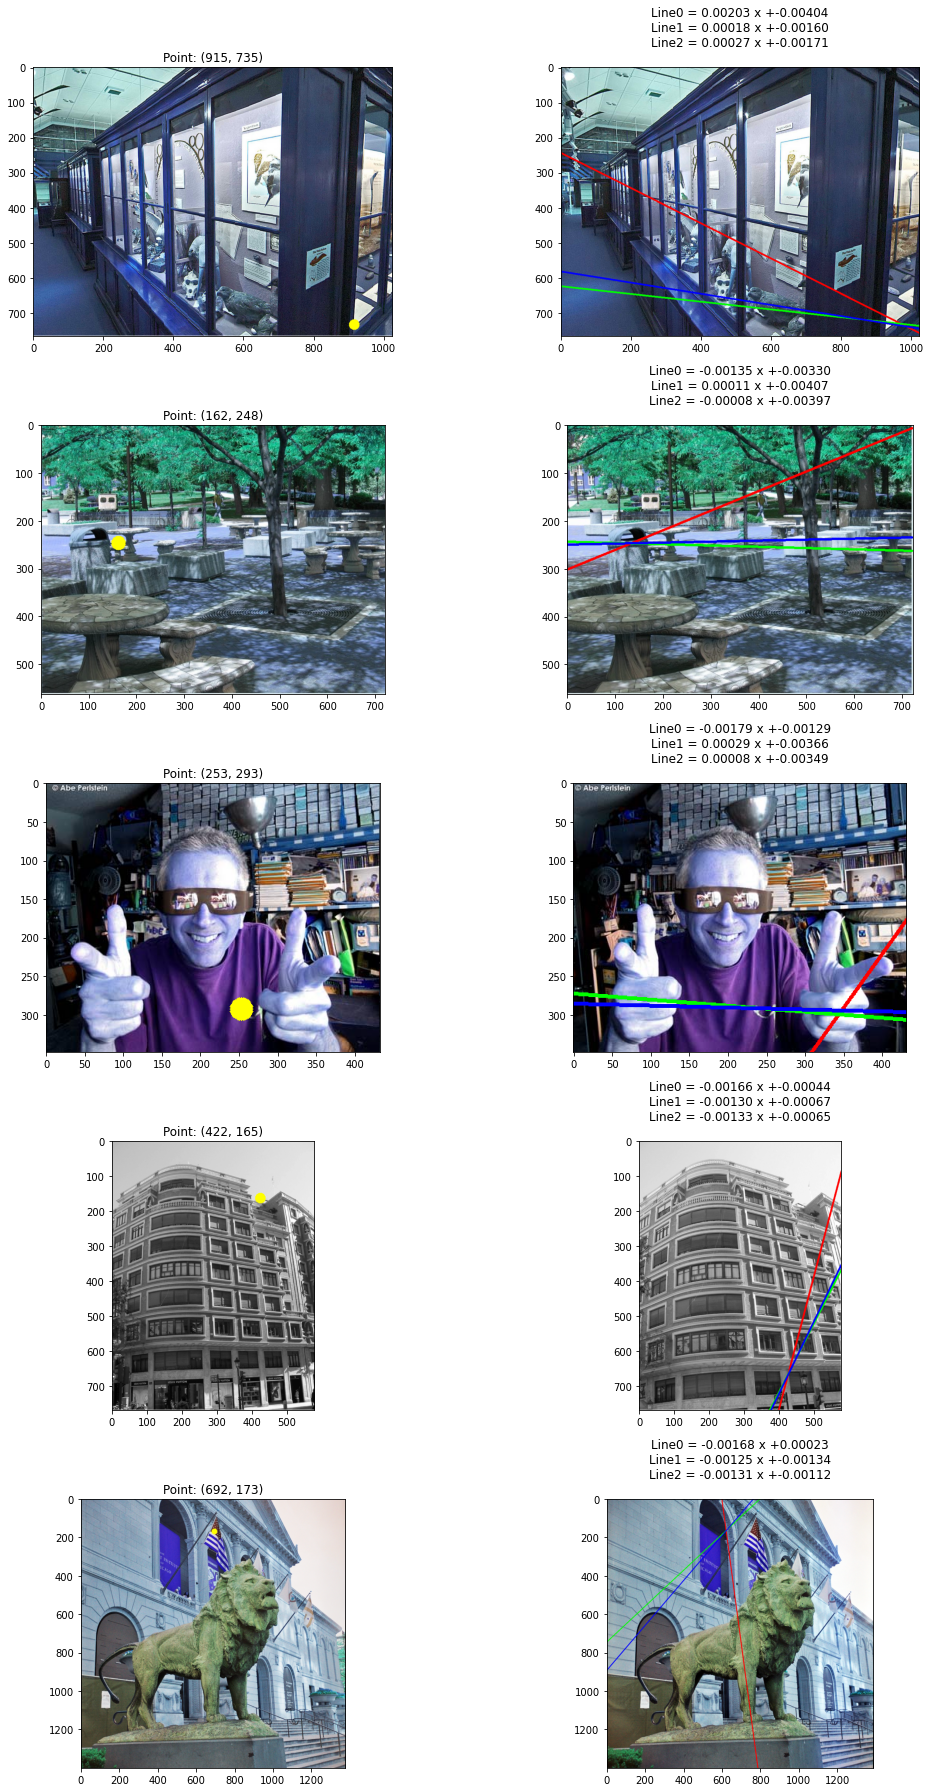

In [20]:
img_dir = "images" 
if os.path.exists(img_dir):
    if os.listdir(img_dir) is []:
        print("No images!")
        exit(0)
    fig = plt.figure(figsize=(15, 25))
    
    for i in range(5):
        
        #image1_path = img_dir + "/image" + str(i+1) + str(1) + ".png"
        #image2_path = img_dir + "/image" + str(i+1) + str(2) + ".png"
        #image1 = cv2.imread(image1_path)
        #image2 = cv2.imread(image2_path)
        image1 = cv2.imread('./images/image'+str(i+1)+'1.png')
        image2 = cv2.imread('./images/image'+str(i+1)+'2.png')
        
        
        F0 = fundamentals[i, 0]
        F1 = fundamentals[i, 1]
        F2 = fundamentals[i, 2]
        
        
        
        #M0 shape 5 2 50 2
        kps1 = M0[i,0,0].numpy()
        kps2 = M0[i,1,0].numpy()
        
        
        kps1 = np.int32(kps1)
        kps2 = np.int32(kps2)
        
        
        
#         kps1_0 = kps1[mask0.ravel()==1]
#         kps1_1 = kps1[mask1.ravel()==1]
#         kps1_2 = kps1[mask2.ravel()==1]
        
#         kps2_0 = kps2[mask0.ravel()==1]     
#         kps2_1 = kps2[mask1.ravel()==1]
#         kps2_2 = kps2[mask2.ravel()==1]
        
#         print('kps1 :', kps1)
#         print('kps1_0 :', kps1_0)
#         print('kps2_0 :', kps2_0)
#         print('kps1_1 :', kps1_1)
#         print('kps1_2 :', kps1_2)
        

        
        # calculate epilines
        lines0 = cv2.computeCorrespondEpilines(kps1.reshape(-1,1,2), 2, F0.numpy()) #F0 kps2_0[0]
        lines1 = cv2.computeCorrespondEpilines(kps1.reshape(-1,1,2), 2, F1.numpy()) #F1
        lines2 = cv2.computeCorrespondEpilines(kps1.reshape(-1,1,2), 2, F2.numpy()) #F2
        
        lines0 = lines0.reshape(-1,3)
        lines1 = lines1.reshape(-1,3)
        lines2 = lines2.reshape(-1,3)
        

        #draw kp in image1, epilines in image2
        image3, image4 = drawlines_new(image1, image2, kps1, kps2, lines0[0], lines1[0], lines2[0]) 

        
        ax1 = fig.add_subplot(5, 2, i*2+1)
        plt.title('Point: ({:d}, {:d})'.format(int(kps1[0]), int(kps1[1])))
        plt.tight_layout()
        plt.imshow(image3)
        ax2 = fig.add_subplot(5, 2, i*2+2)
        plt.title('Line0 = {:.5f} x +{:.5f}\nLine1 = {:.5f} x +{:.5f}\nLine2 = {:.5f} x +{:.5f}\n'.format(lines0[0,0]/lines0[0,2],lines0[0,1]/lines0[0,2], 
                                                                                                          lines1[0,0]/lines1[0,2],lines1[0,1]/lines1[0,2], 
                                                                                                          lines2[0,0]/lines2[0,2],lines2[0,1]/lines2[0,2],))
        
        plt.savefig("eplines.jpg")
        plt.imshow(image4)



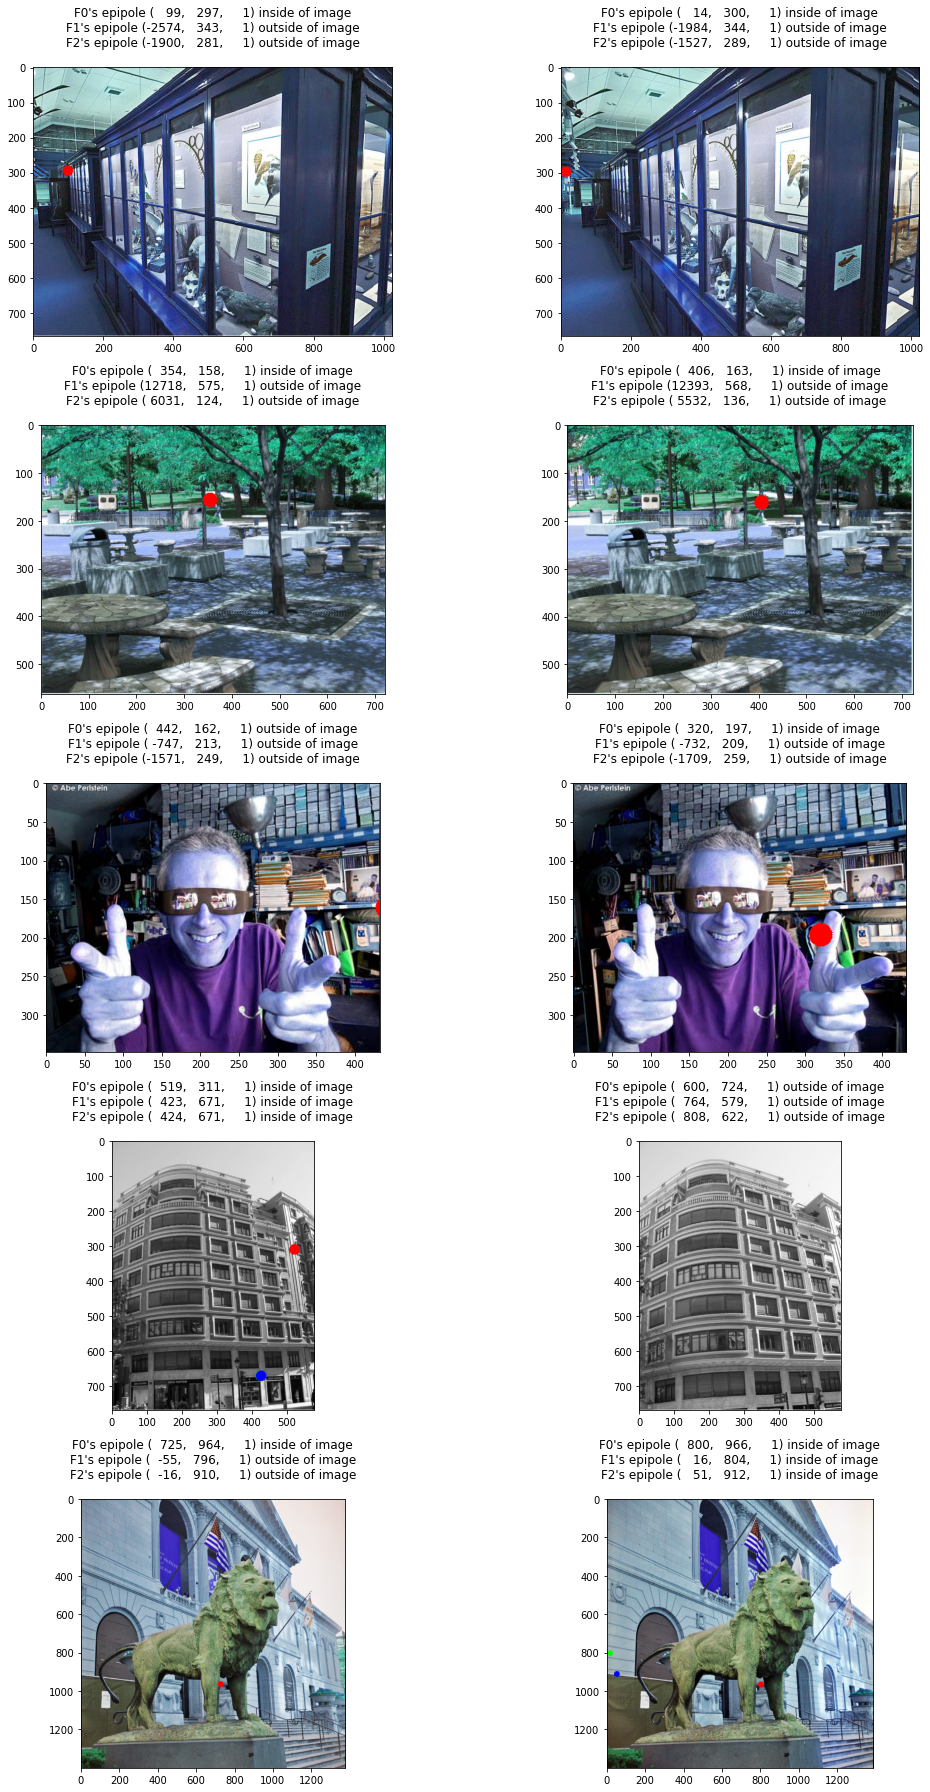

In [21]:
fig = plt.figure(figsize=(15, 25))
for i in range(5):
    image1 = cv2.imread('./images/image'+str(i+1)+'1.png')
    image2 = cv2.imread('./images/image'+str(i+1)+'2.png')
    
    h, w, c = image1.shape
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    capt1 = ""
    capt2 = ""
    
    
    for j in range(3):
        image1 = drawepipoles(image1, epipoles[i, j, 0, :2], colors[j])
        image2 = drawepipoles(image2, epipoles[i, j, 1, :2], colors[j])
        capt1 +=  "F{:d}'s epipole ({:5d}, {:5d}, {:5d}) ".format(j, int(epipoles[i, j, 0, 0]), int(epipoles[i, j, 0, 1]), int(epipoles[i, j, 1, 2]))
        capt2 +=  "F{:d}'s epipole ({:5d}, {:5d}, {:5d}) ".format(j, int(epipoles[i, j, 1, 0]), int(epipoles[i, j, 1, 1]), int(epipoles[i, j, 1, 2]))
        
        if 0 < epipoles[i, j, 0, 0] < w and 0 < epipoles[i, j, 0, 1] < h:
            capt1 +=  "inside of image\n"
        else:
            capt1 +=  "outside of image\n"
        
        if 0 < epipoles[i, j, 1, 0] < w and 0 < epipoles[i, j, 1, 1] < h:
            capt2 +=  "inside of image\n"
        else:
            capt2 +=  "outside of image\n"
    
    
    ax1 = fig.add_subplot(5, 2, i*2+1)
    plt.tight_layout()
    plt.title(capt1)
    plt.imshow(image1)
    ax2 = fig.add_subplot(5, 2, i*2+2)
    plt.title(capt2)
    plt.savefig("eps.jpg")
    plt.imshow(image2)